In [22]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from algorithms import globals
import os

In [23]:
def plot_function(curr_f):
    x = np.linspace(globals.def_clamps[0], globals.def_clamps[1], 100)
    y = np.linspace(globals.def_clamps[0], globals.def_clamps[1], 100)
    X, Y = np.meshgrid(x, y)
    objecitve_f = curr_f["func"](ndim=2)

    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = objecitve_f.evaluate([X[i, j], Y[i, j]])

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

    ax.set_title(f"{curr_f['shortname']}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('f(X,Y)')

    plt.show()


In [24]:
def get_records(curr_f):
    adam_path = f'./Adam/adam_logs/adam_records_{curr_f["shortname"]}.csv'
    cmaes_path = f'./CMAES/cmaes_logs/cmaes_records_{curr_f["shortname"]}.csv'

    if not os.path.exists(adam_path):
        Adam_records = None
    else:
        Adam_records = []
        with open(adam_path, mode='r', newline='') as file:
            reader = csv.DictReader(file)
            for row in reader:
                converted_row = {
                    key: (float(value) if key != 'function' else value)
                    for key, value in row.items()
                }
                Adam_records.append(converted_row)

    if not os.path.exists(cmaes_path):
        CMAES_records = None
    else:
        CMAES_records = []
        with open(cmaes_path, mode='r', newline='') as file:
            reader = csv.DictReader(file)
            for row in reader:
                converted_row = {
                    key: (float(value) if key != 'function' else value)
                    for key, value in row.items()
                }
                CMAES_records.append(converted_row)

    return (Adam_records, CMAES_records)


In [25]:
def get_run_records(curr_f):
    adam_path = f'./Adam/adam_logs/adam_run_records_{curr_f["shortname"]}.csv'
    cmaes_path = f'./CMAES/cmaes_logs/cmaes_run_records_{curr_f["shortname"]}.csv'

    if not os.path.exists(adam_path):
        Adam_run_records = None
    else:
        Adam_run_records = []
        with open(adam_path, mode='r', newline='') as file:
            reader = csv.DictReader(file)
            for row in reader:
                converted_row = {
                    key: (float(value.strip('[]')) if key != 'function' else value)
                    for key, value in row.items()
                }
                Adam_run_records.append(converted_row)

    if not os.path.exists(cmaes_path):
        CMAES_run_records = None
    else:
        CMAES_run_records = []
        with open(cmaes_path, mode='r', newline='') as file:
            reader = csv.DictReader(file)
            for row in reader:
                converted_row = {
                    key: (float(value.strip('[]')) if key != 'function' else value)
                    for key, value in row.items()
                }
                CMAES_run_records.append(converted_row)

    return (Adam_run_records, CMAES_run_records)


In [26]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

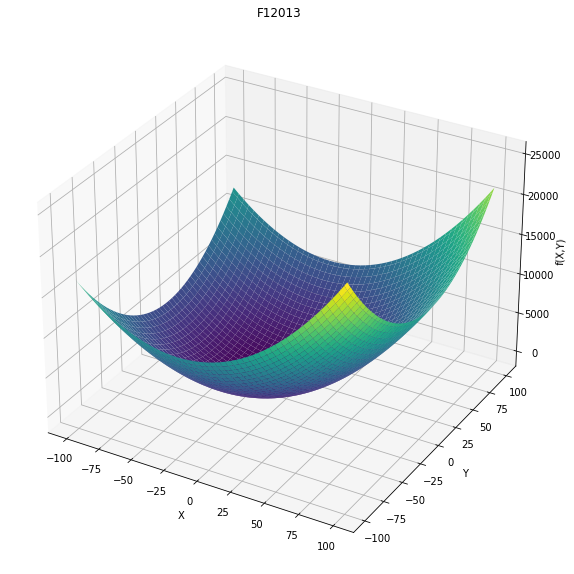

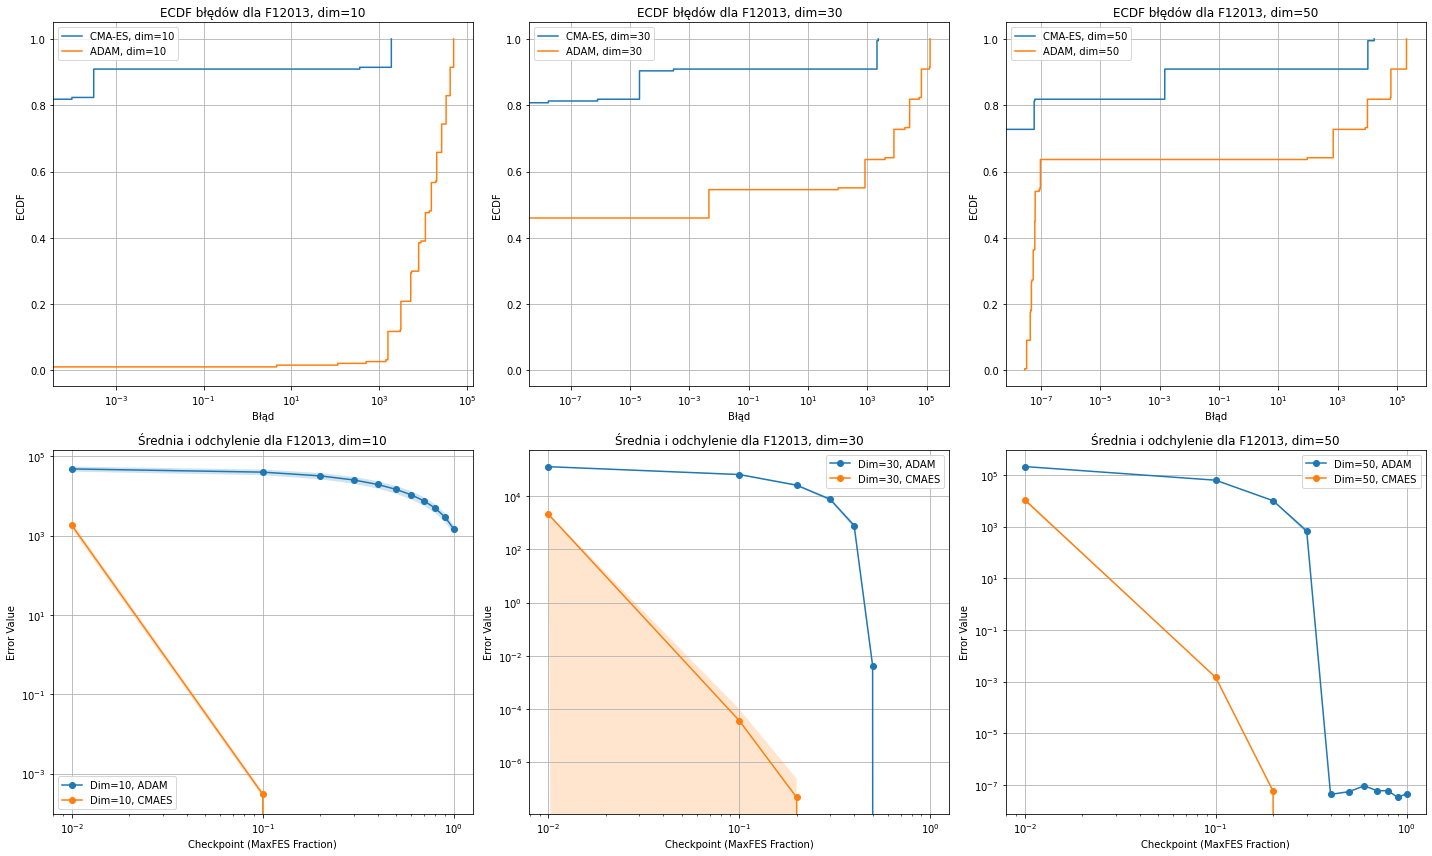

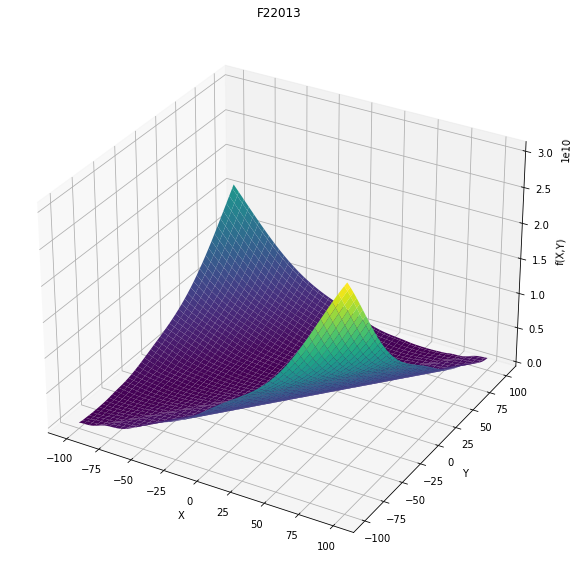

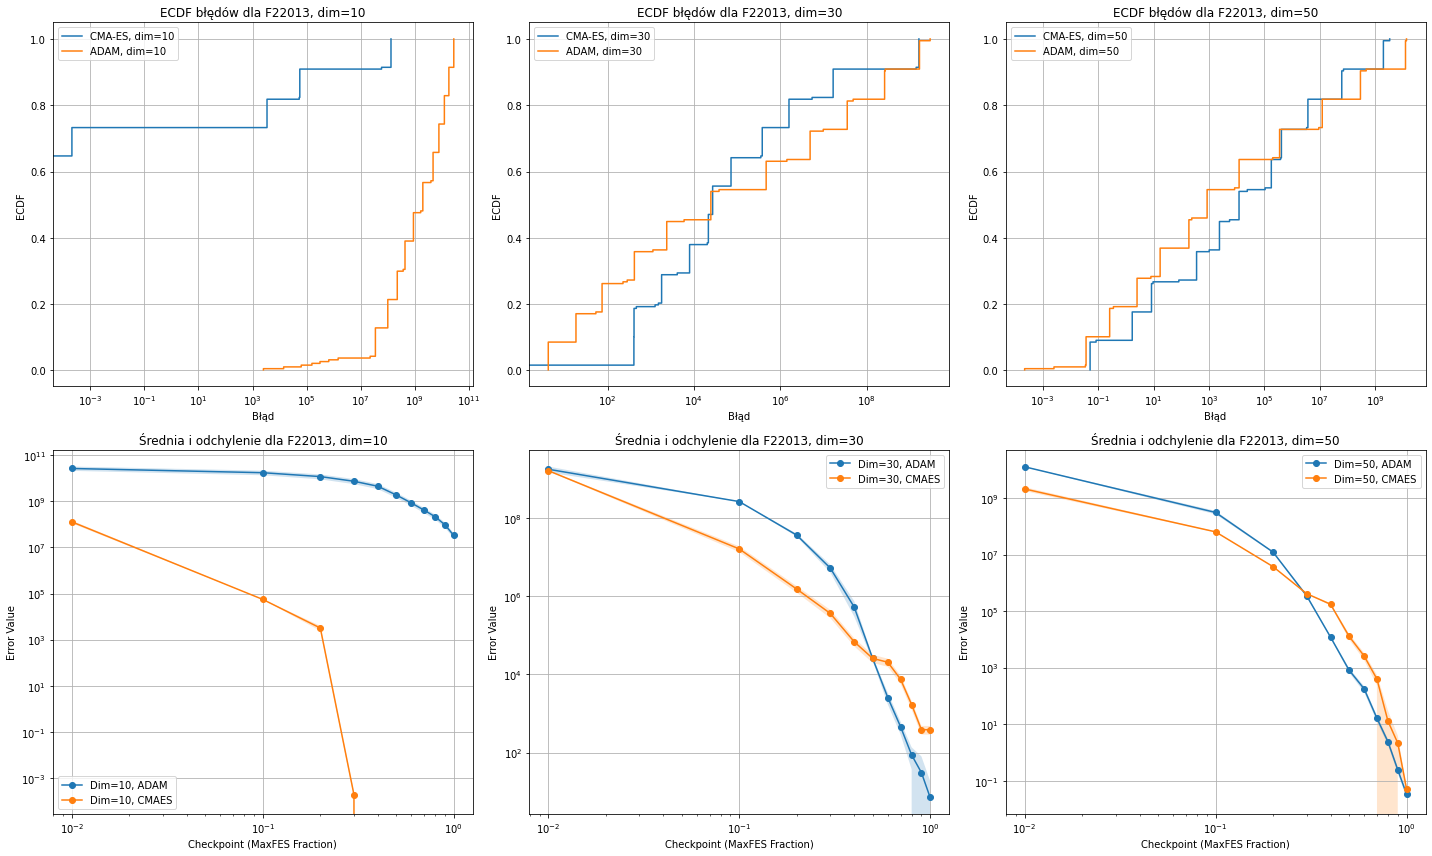

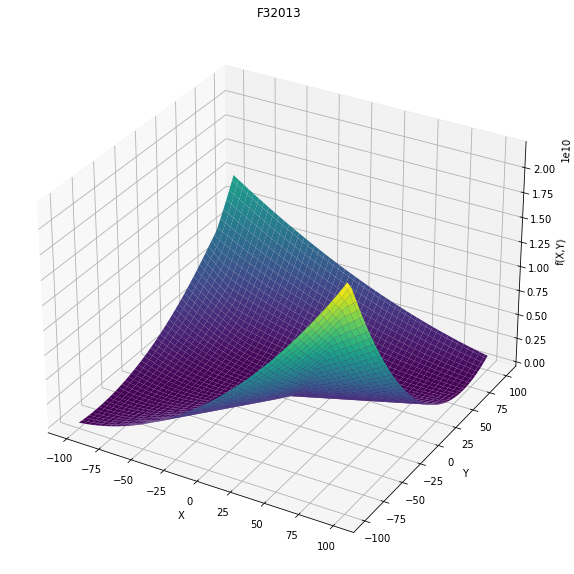

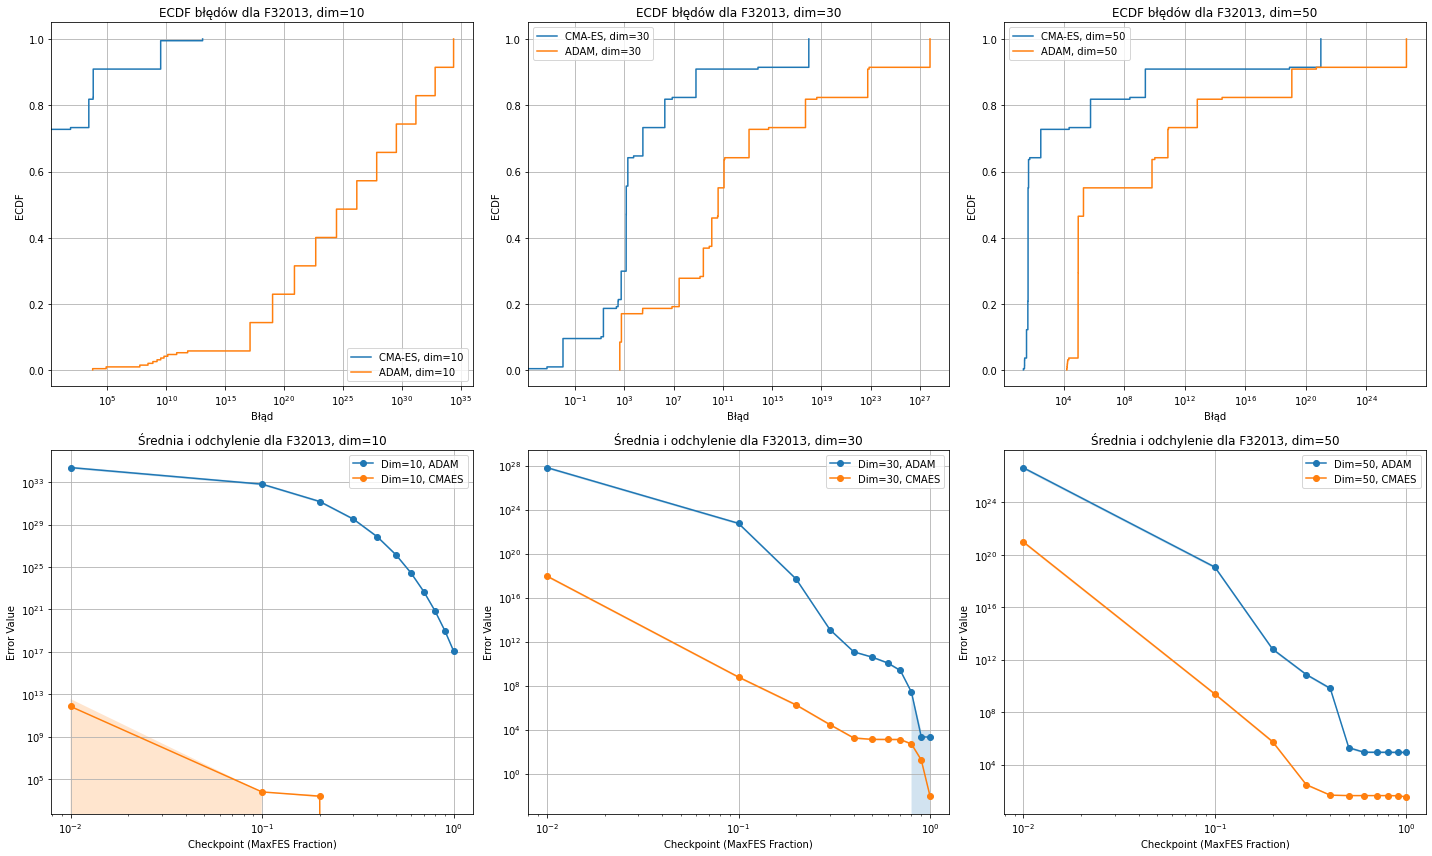

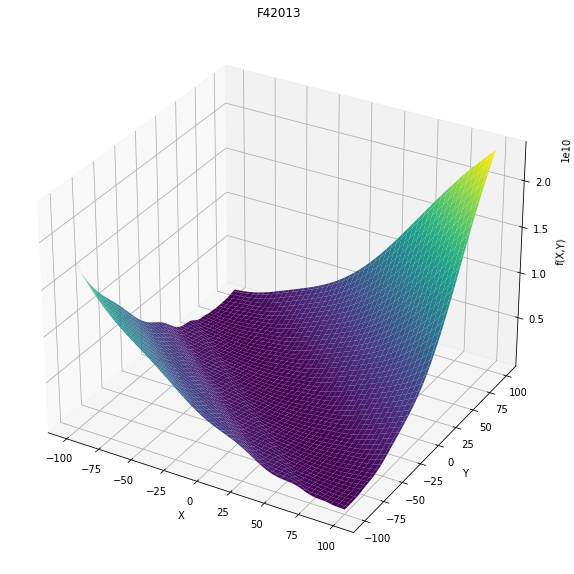

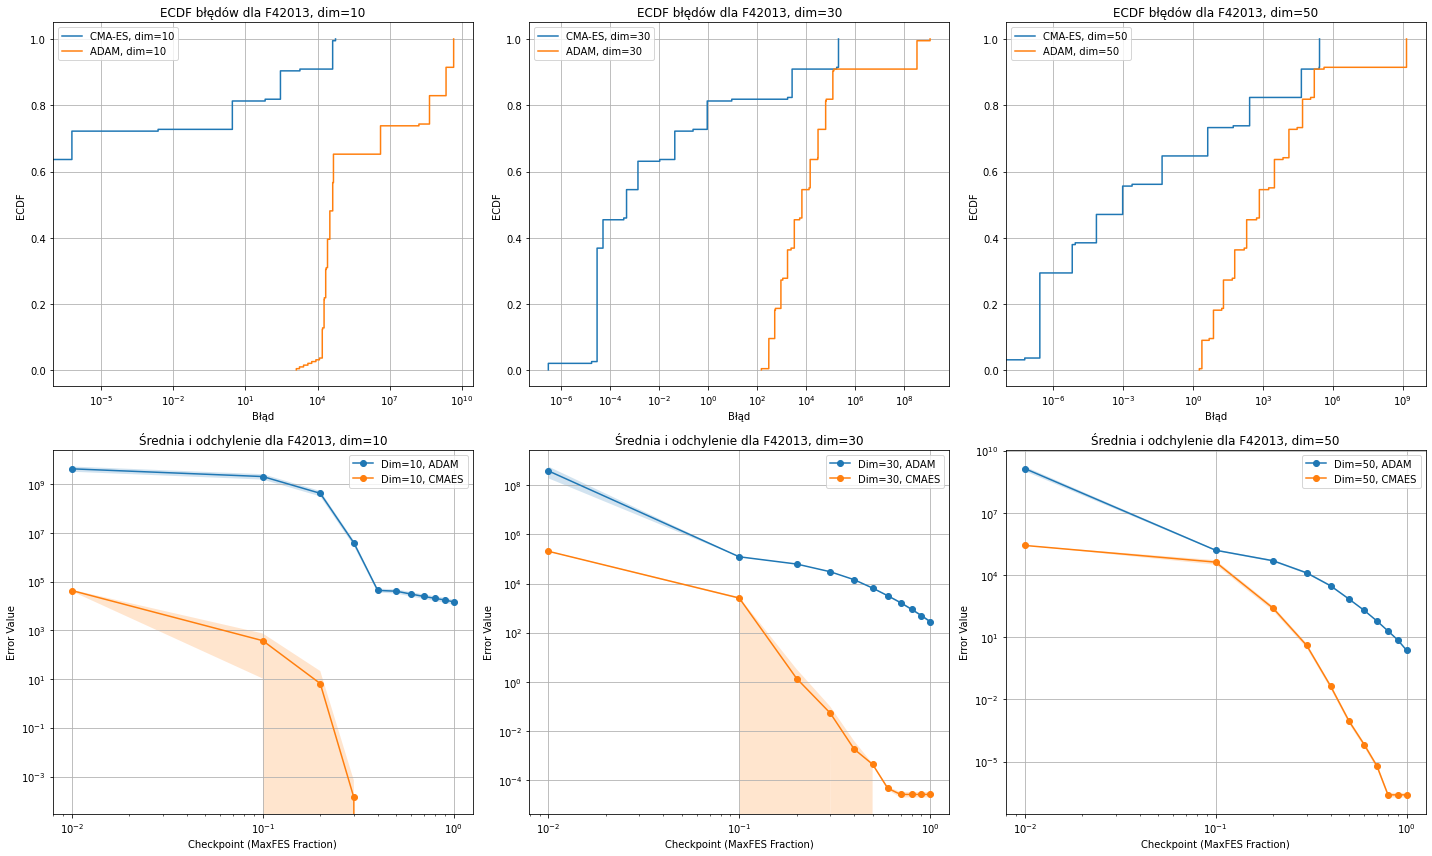

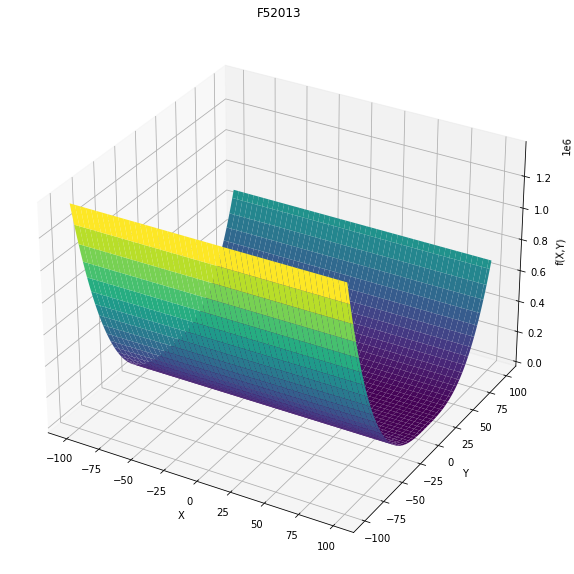

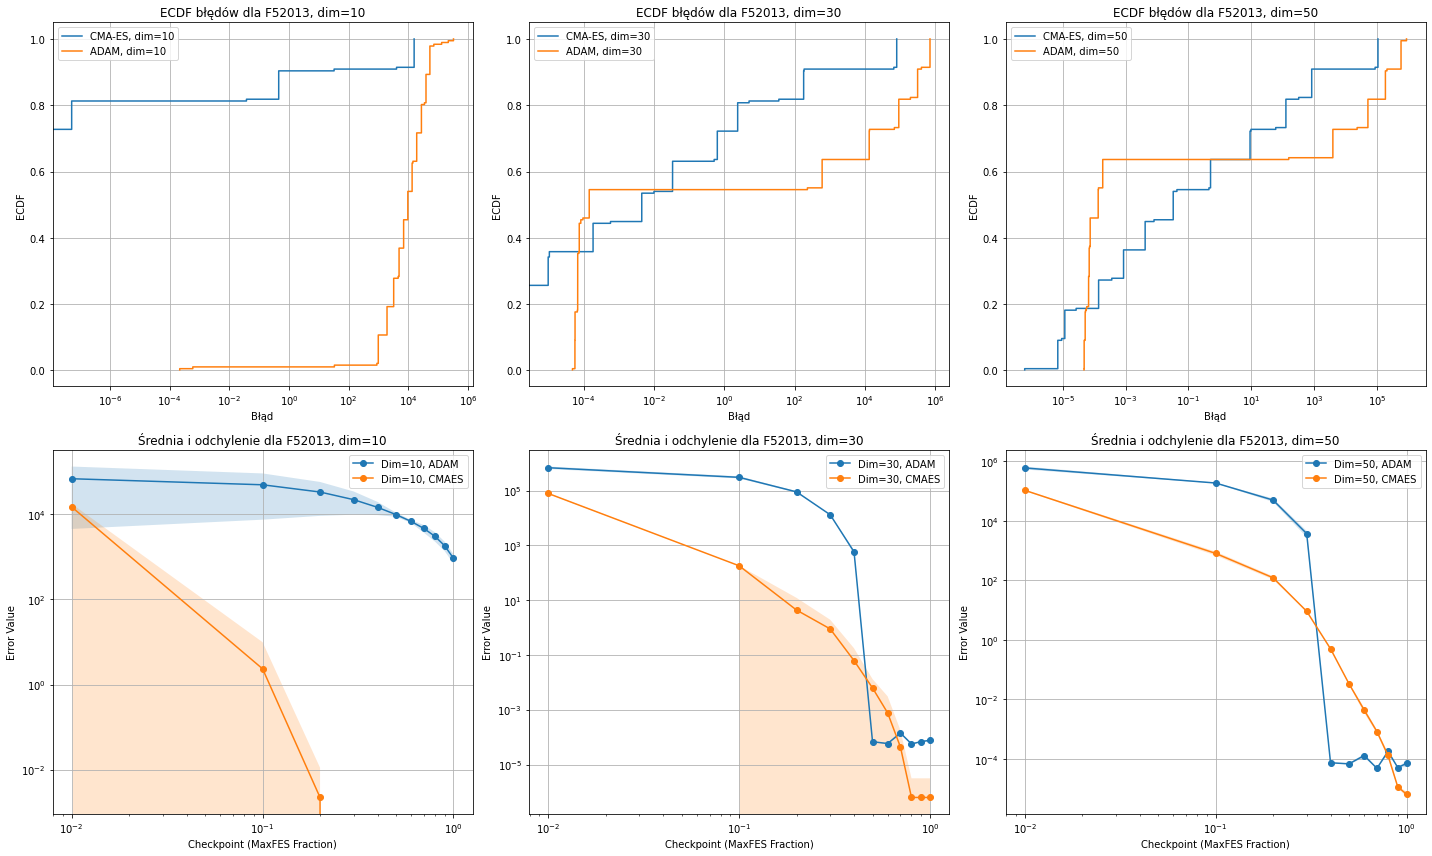

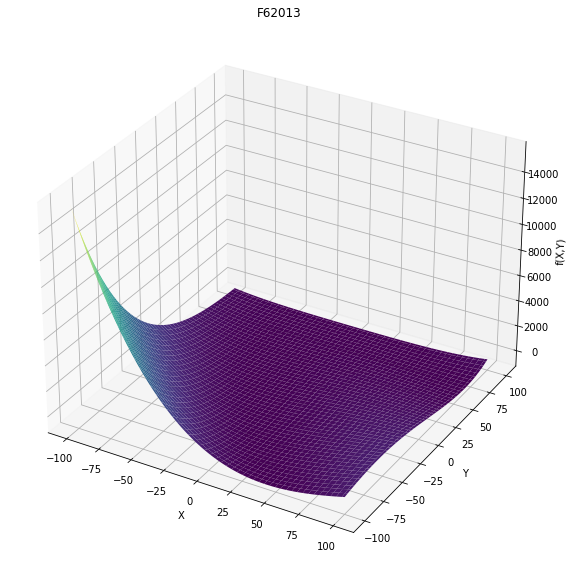

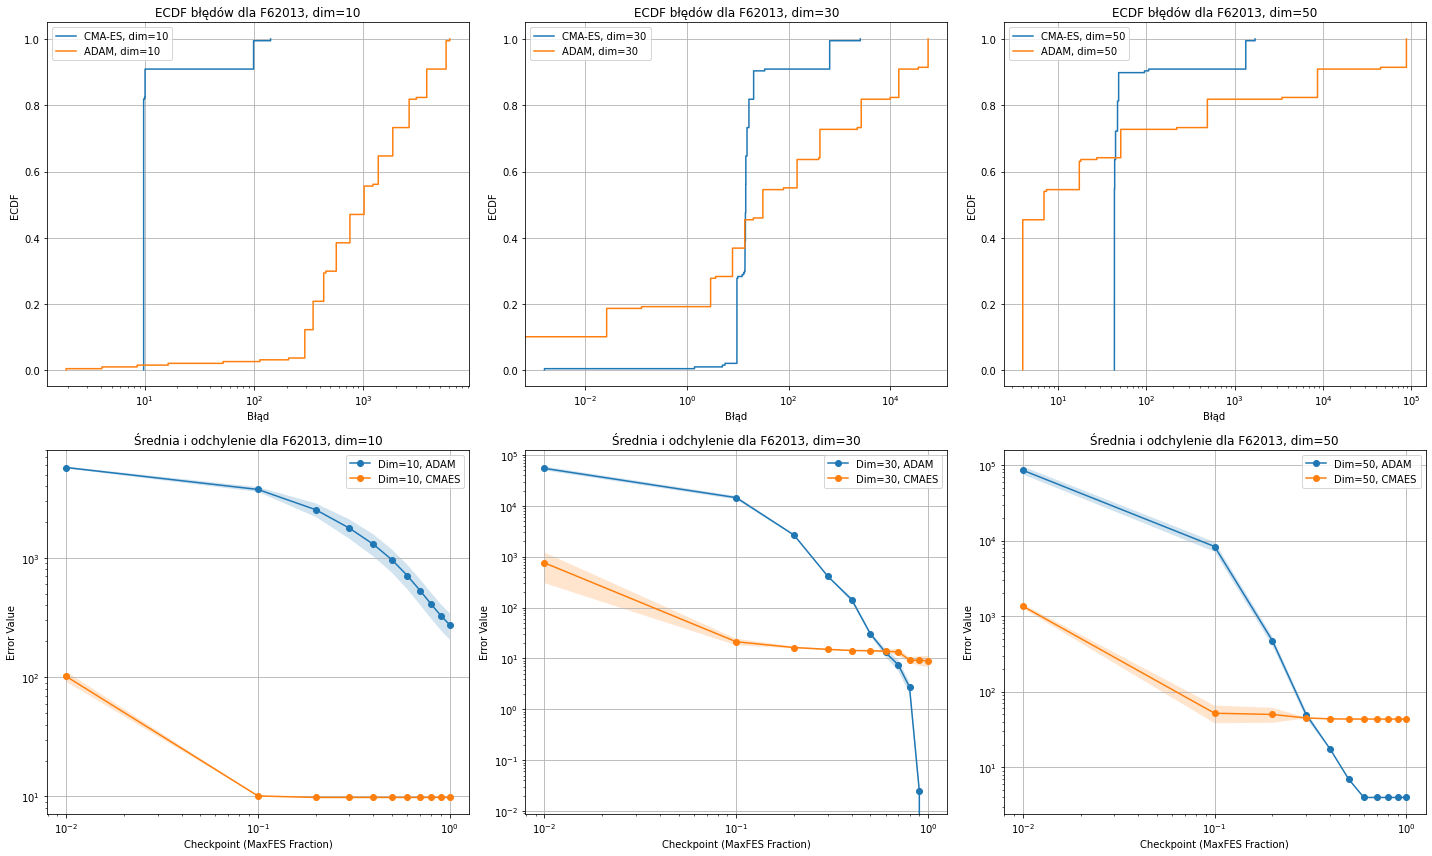

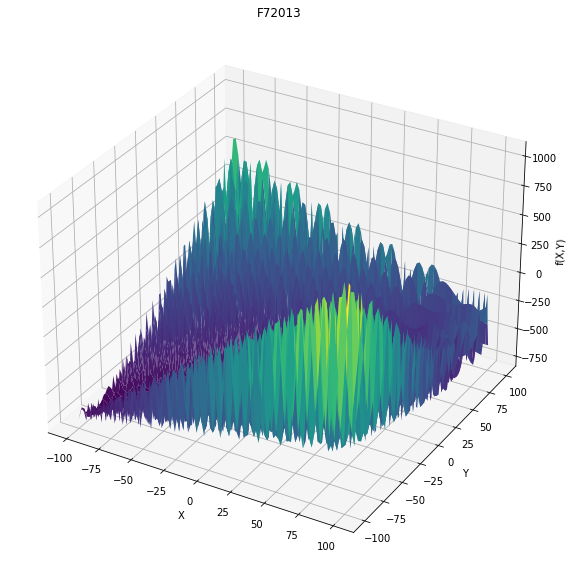

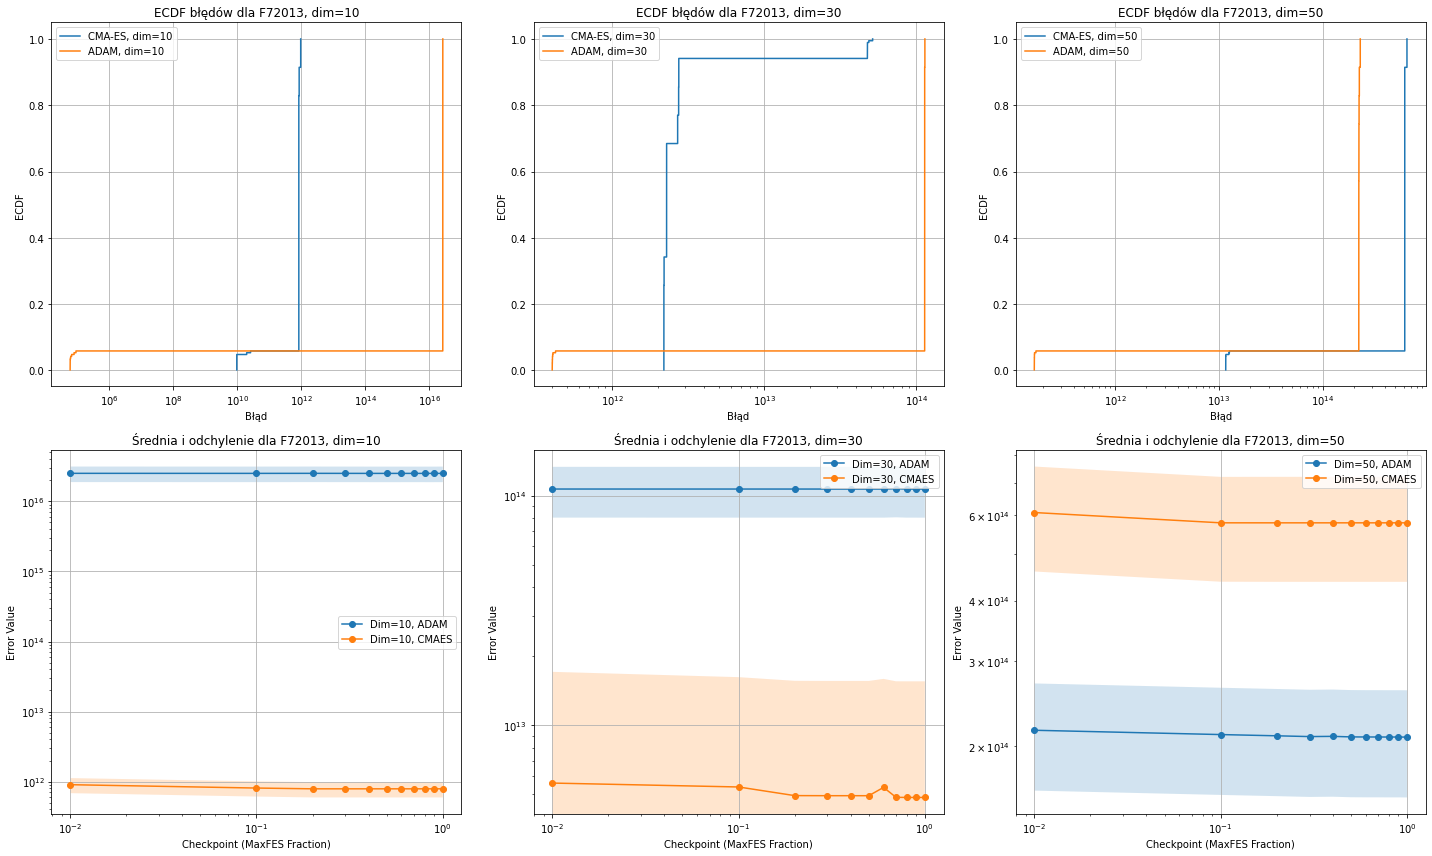

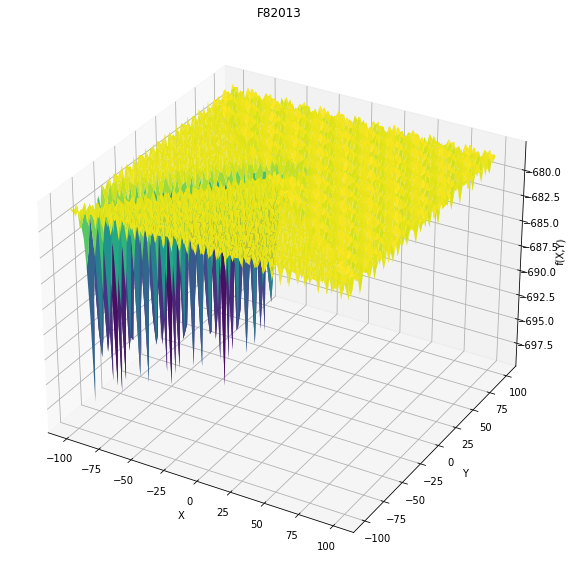

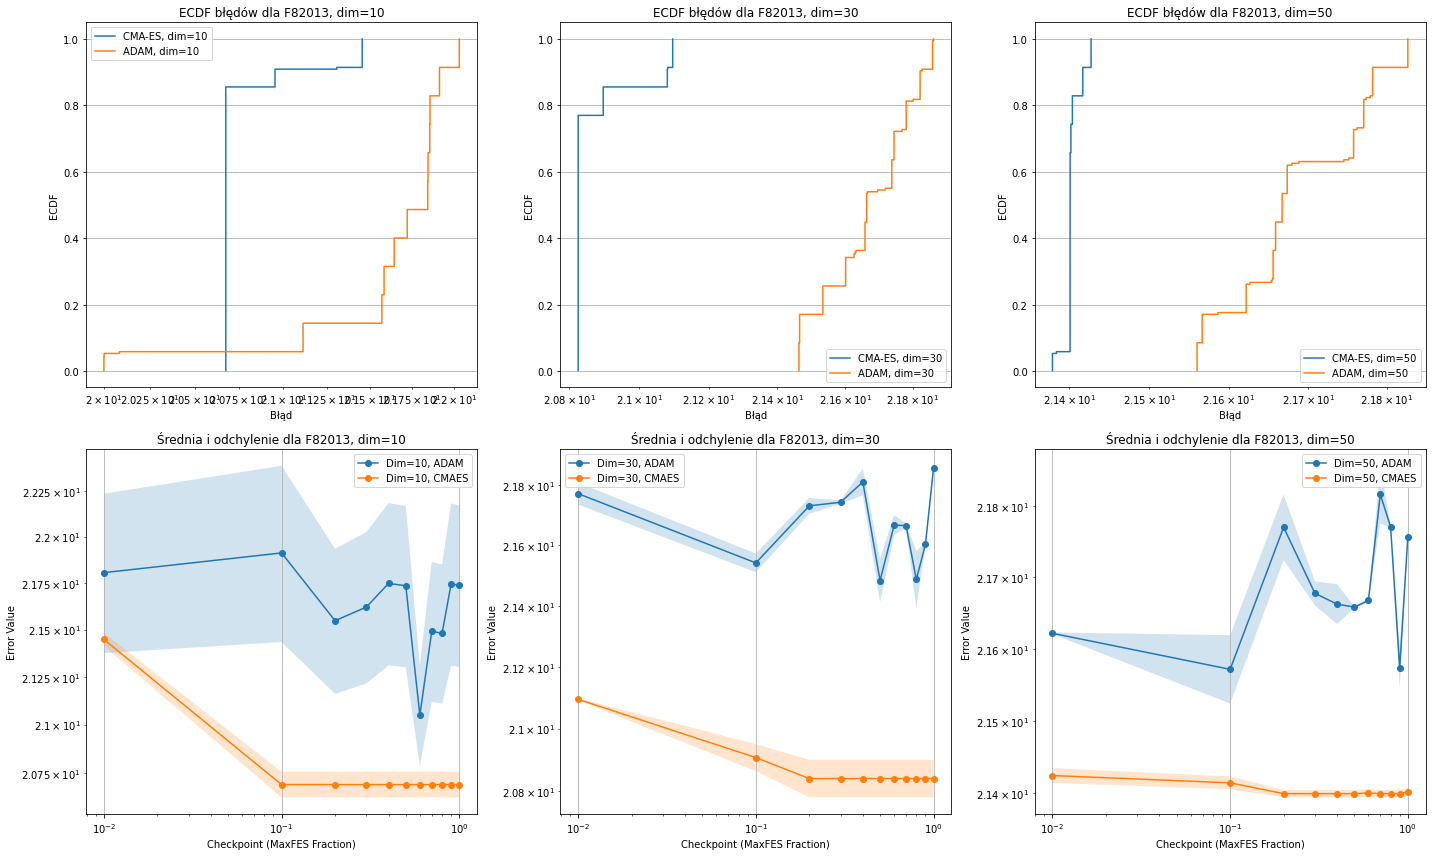

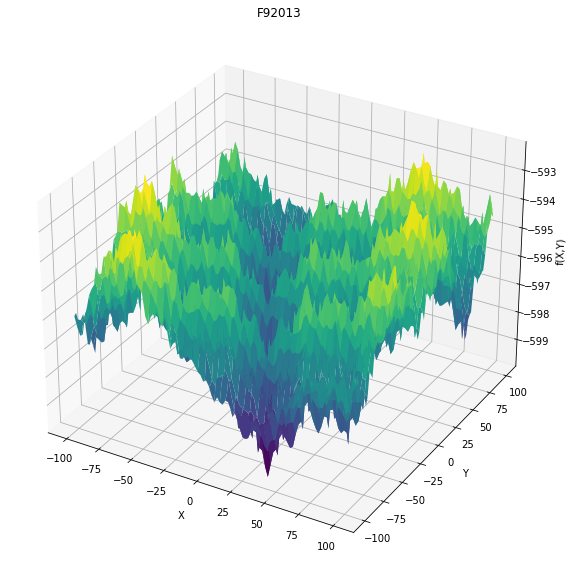

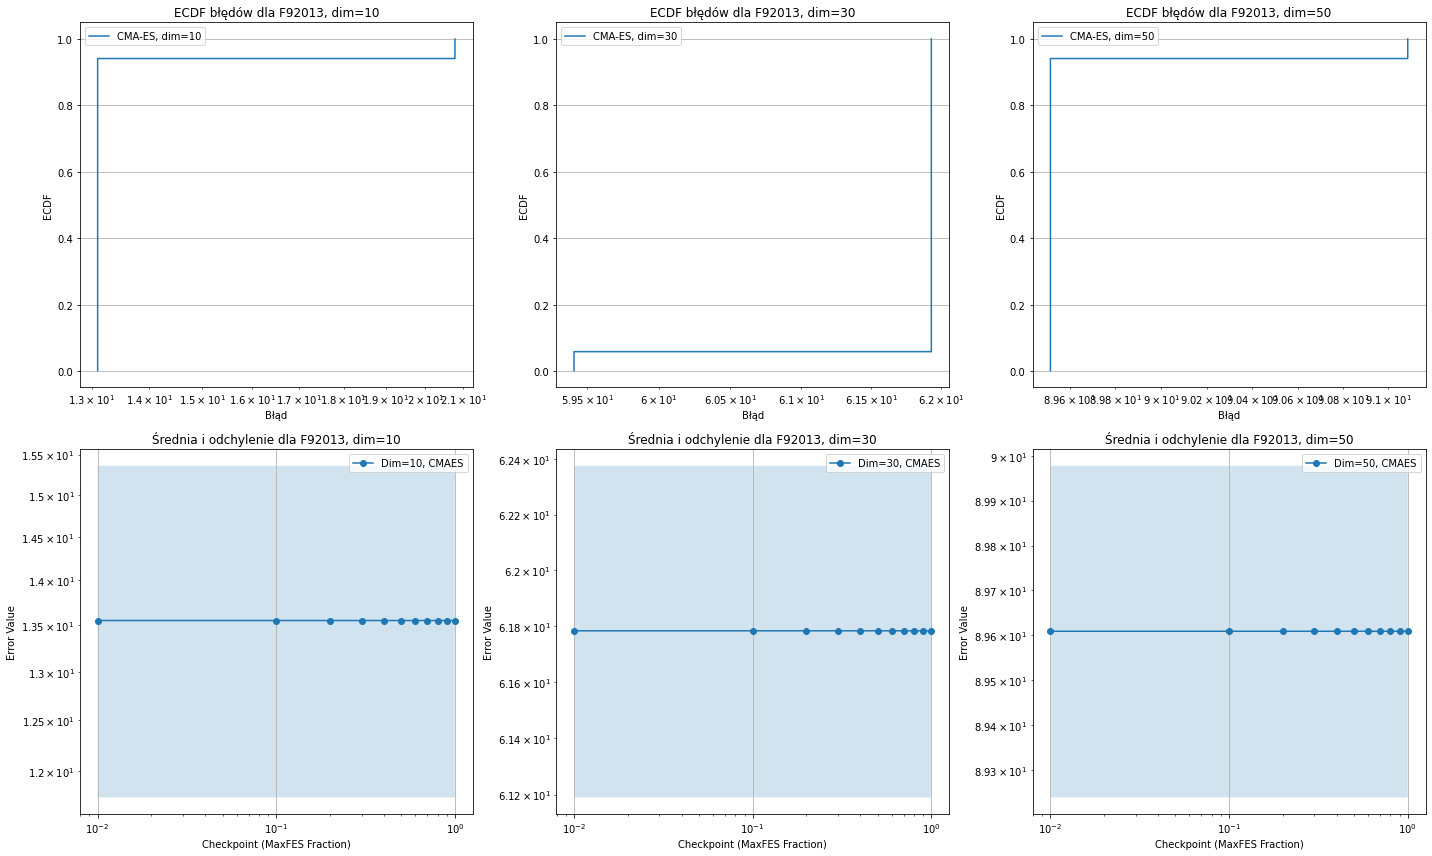

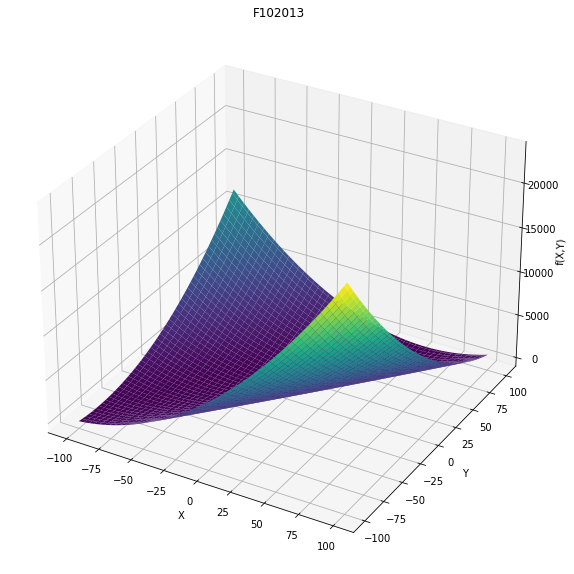

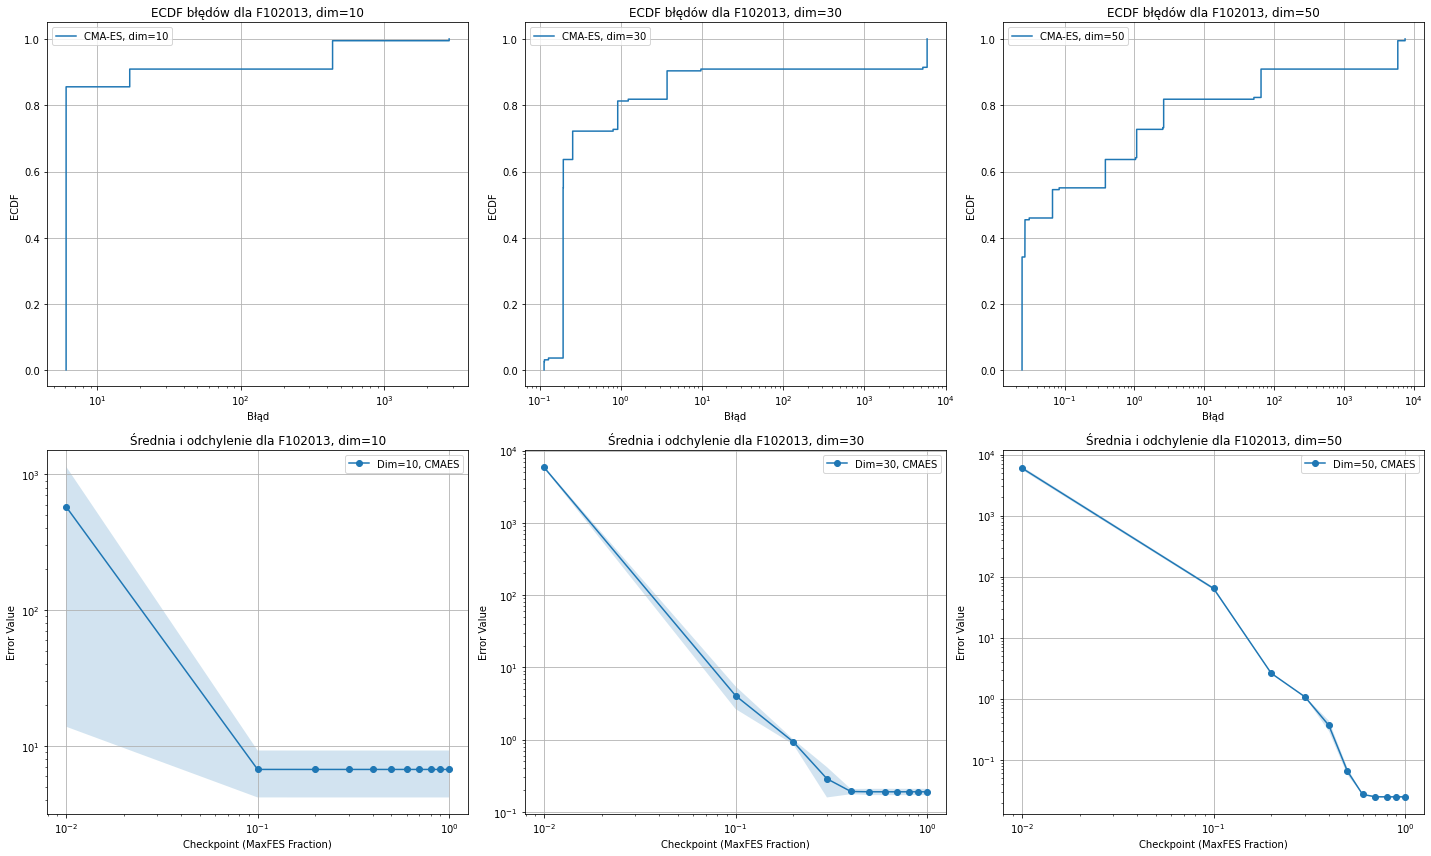

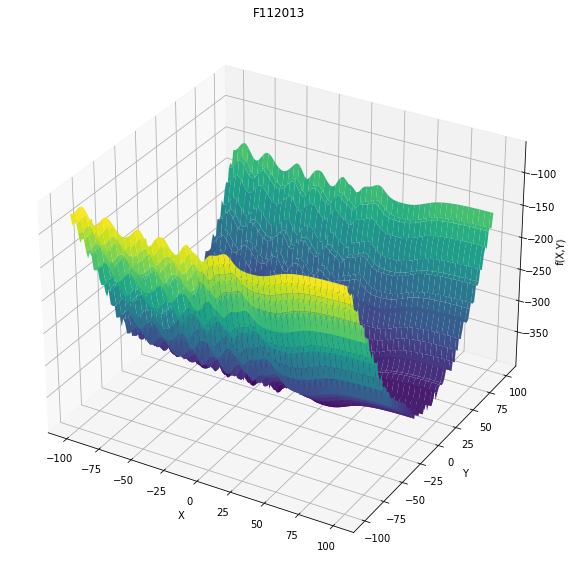

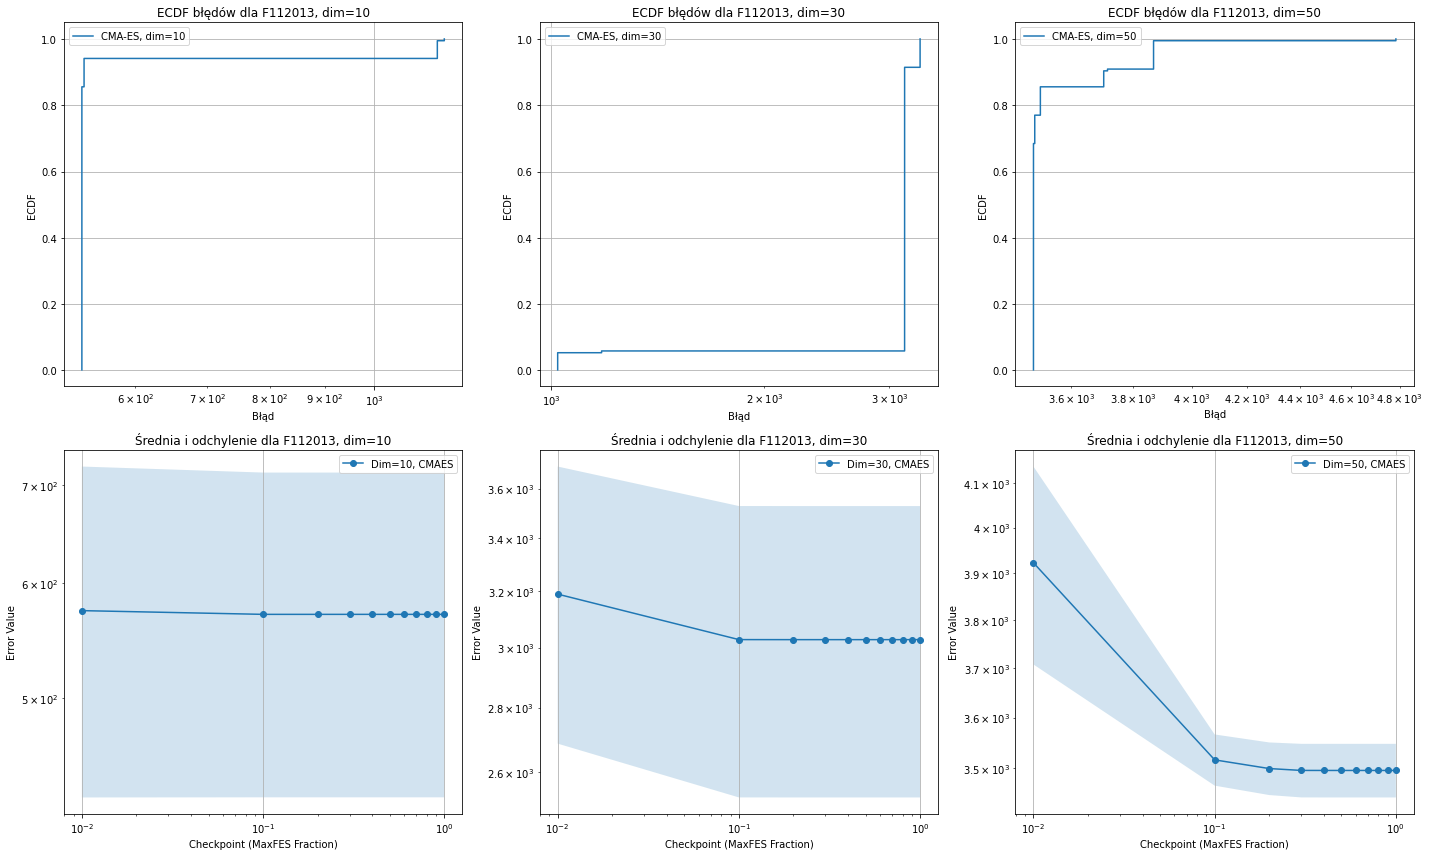

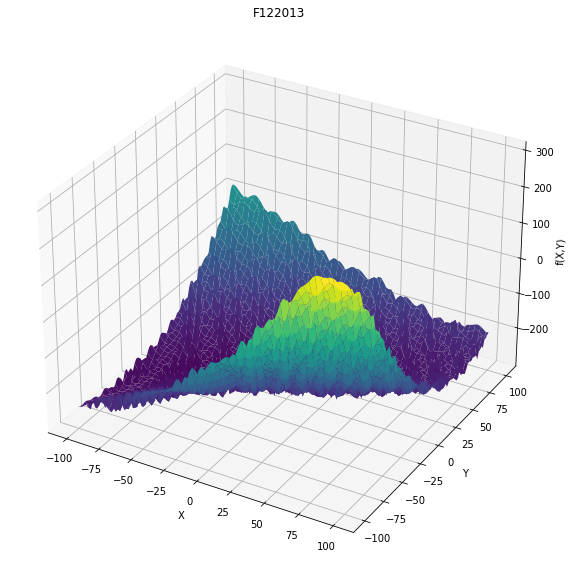

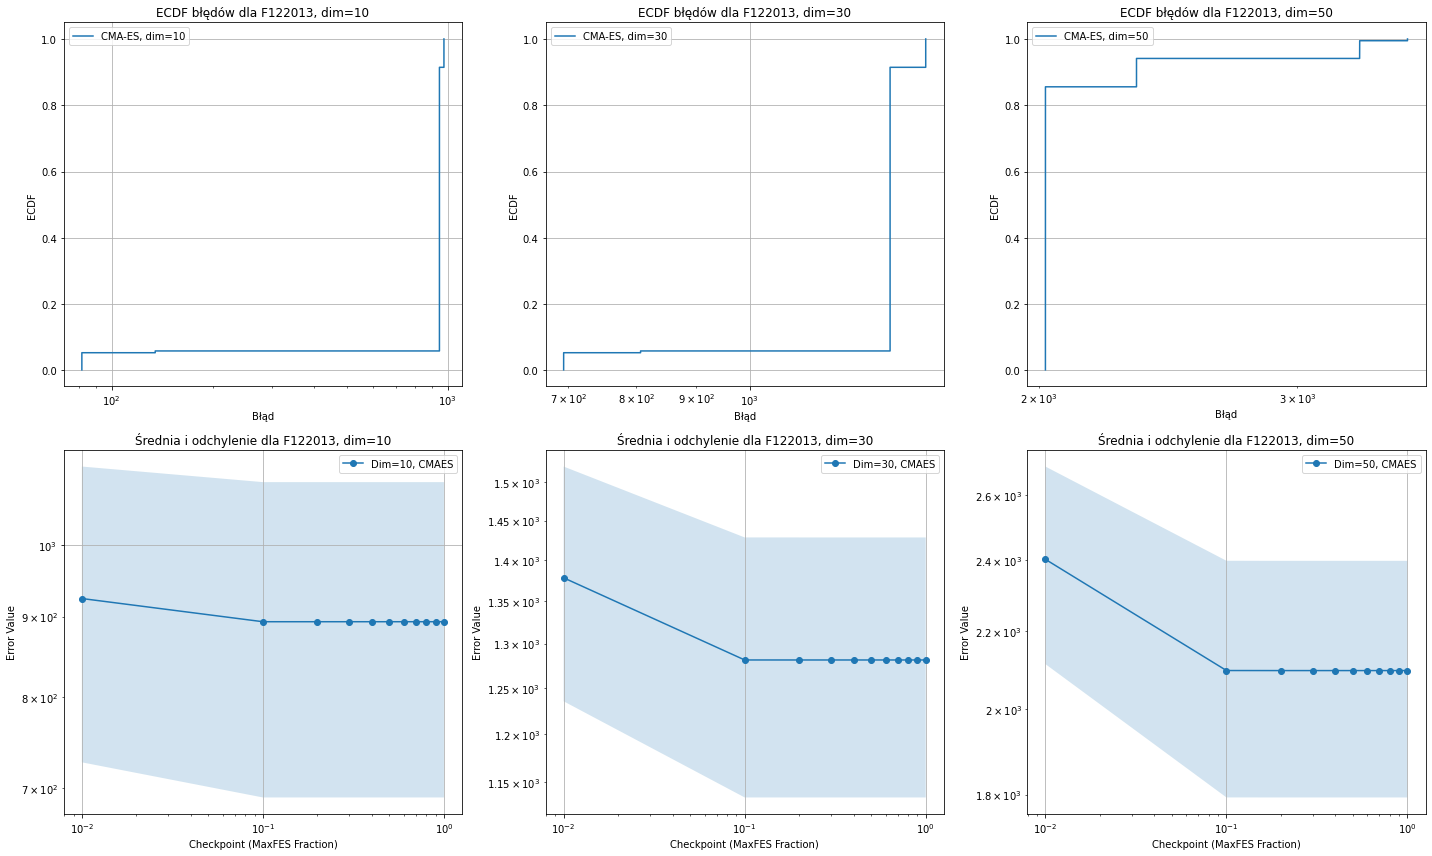

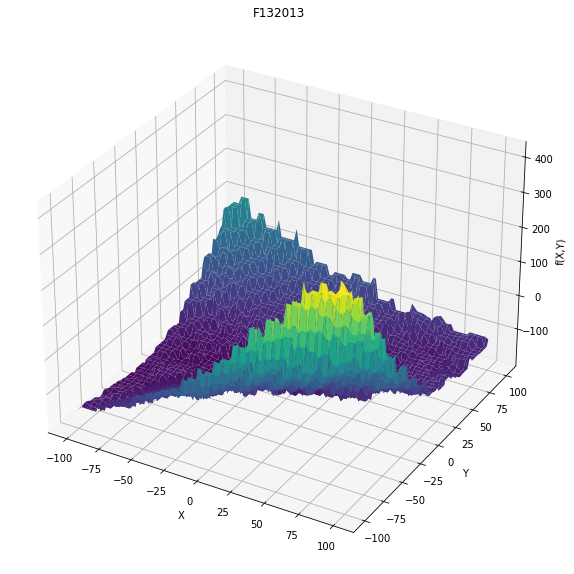

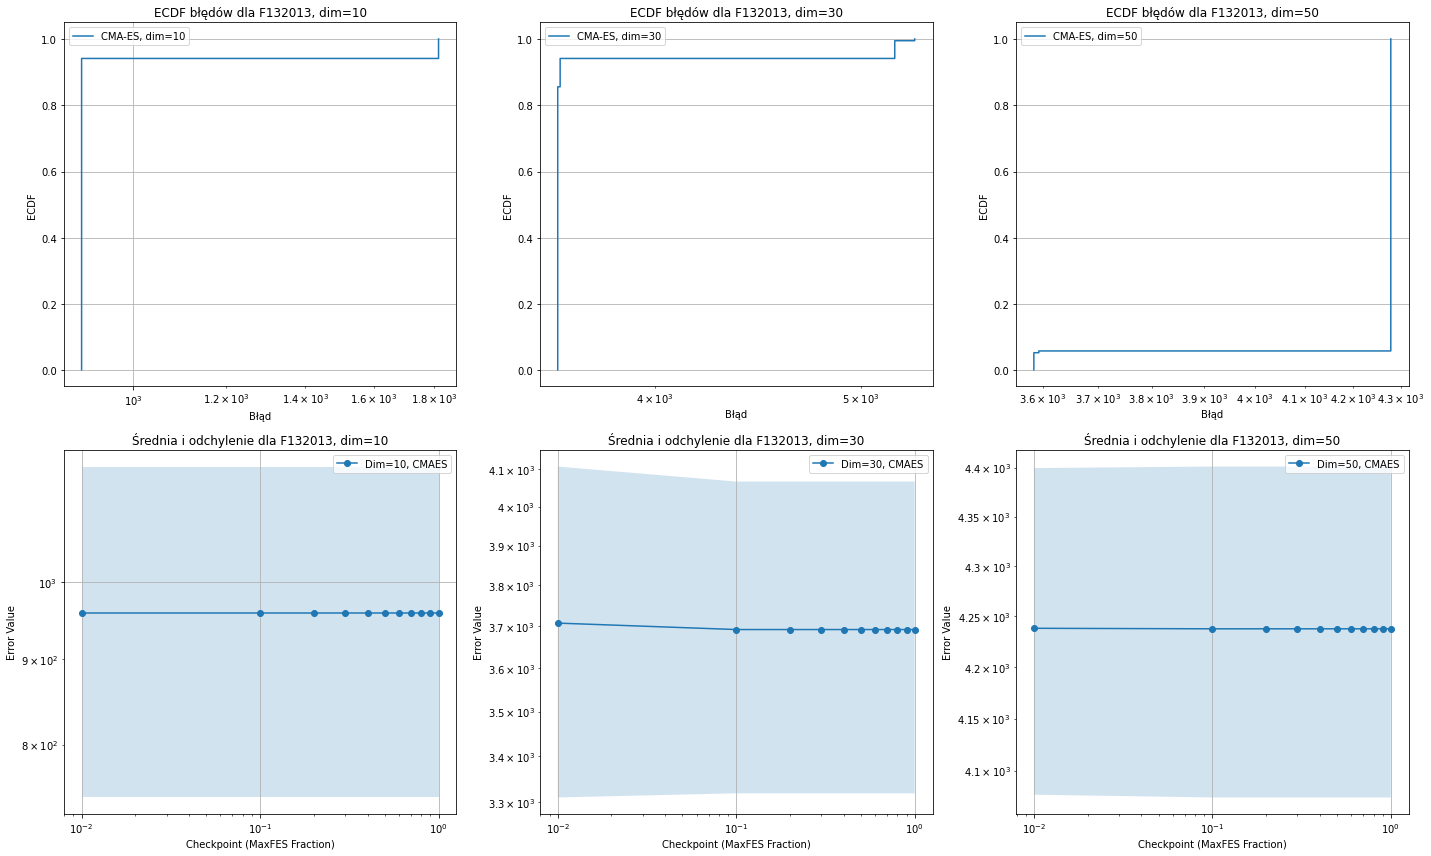

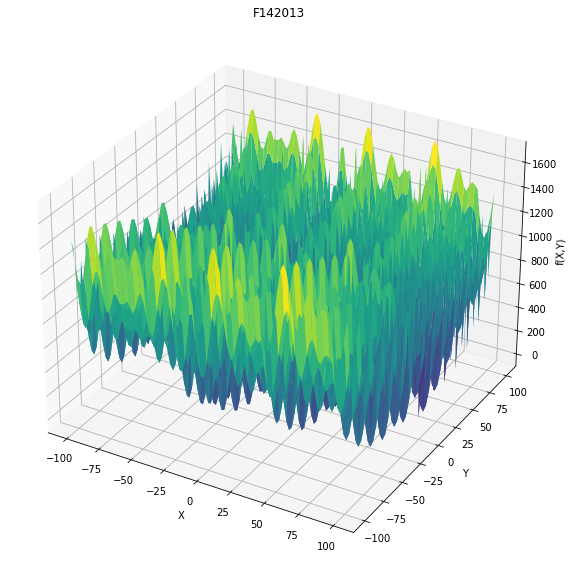

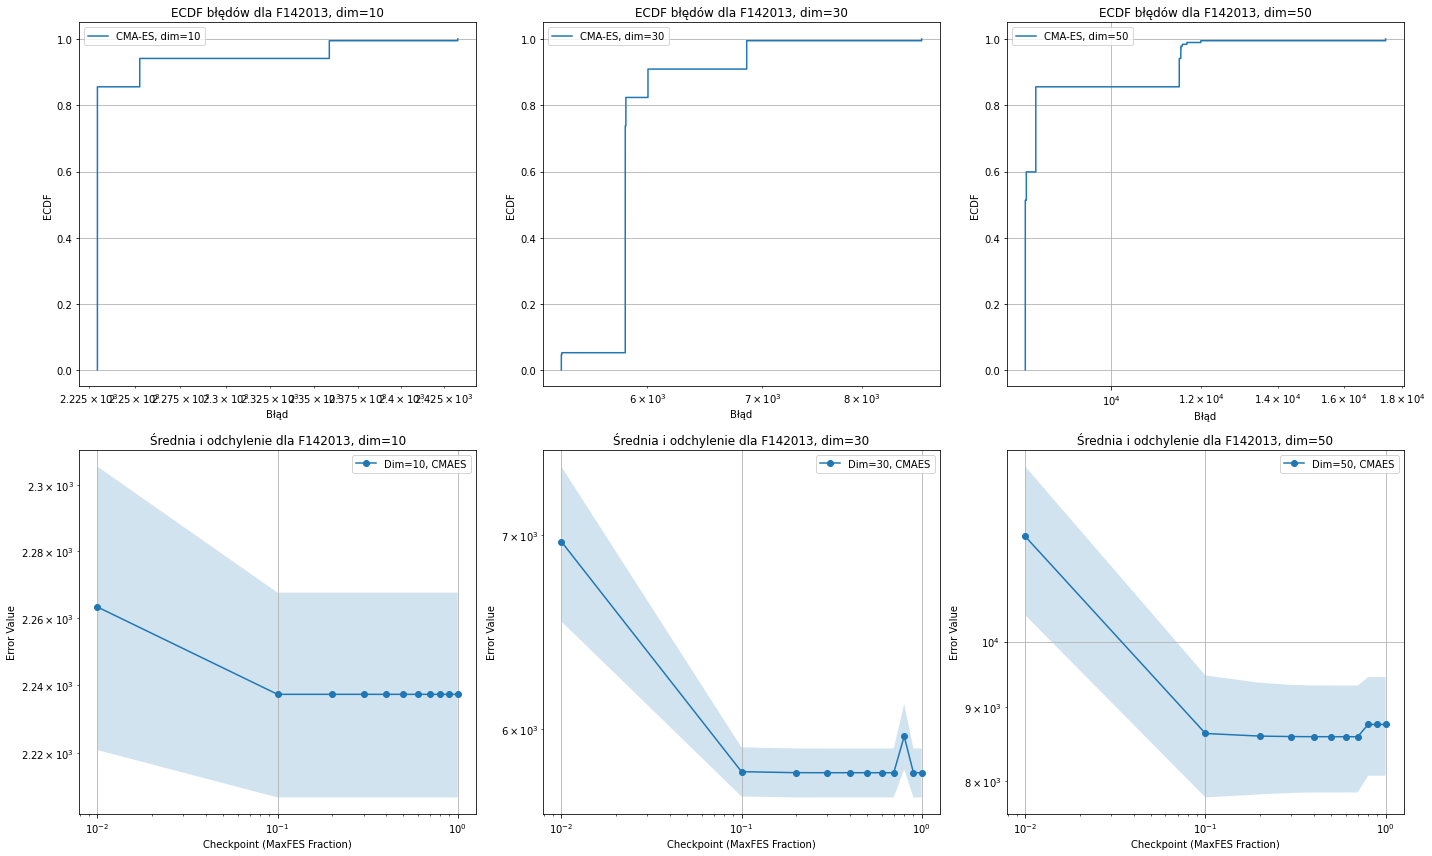

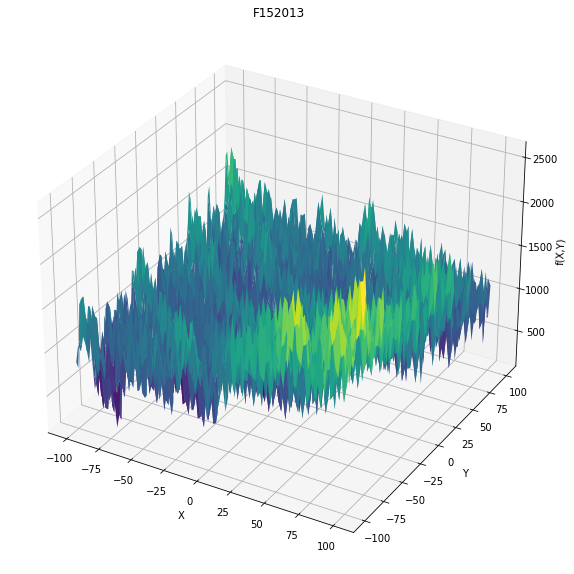

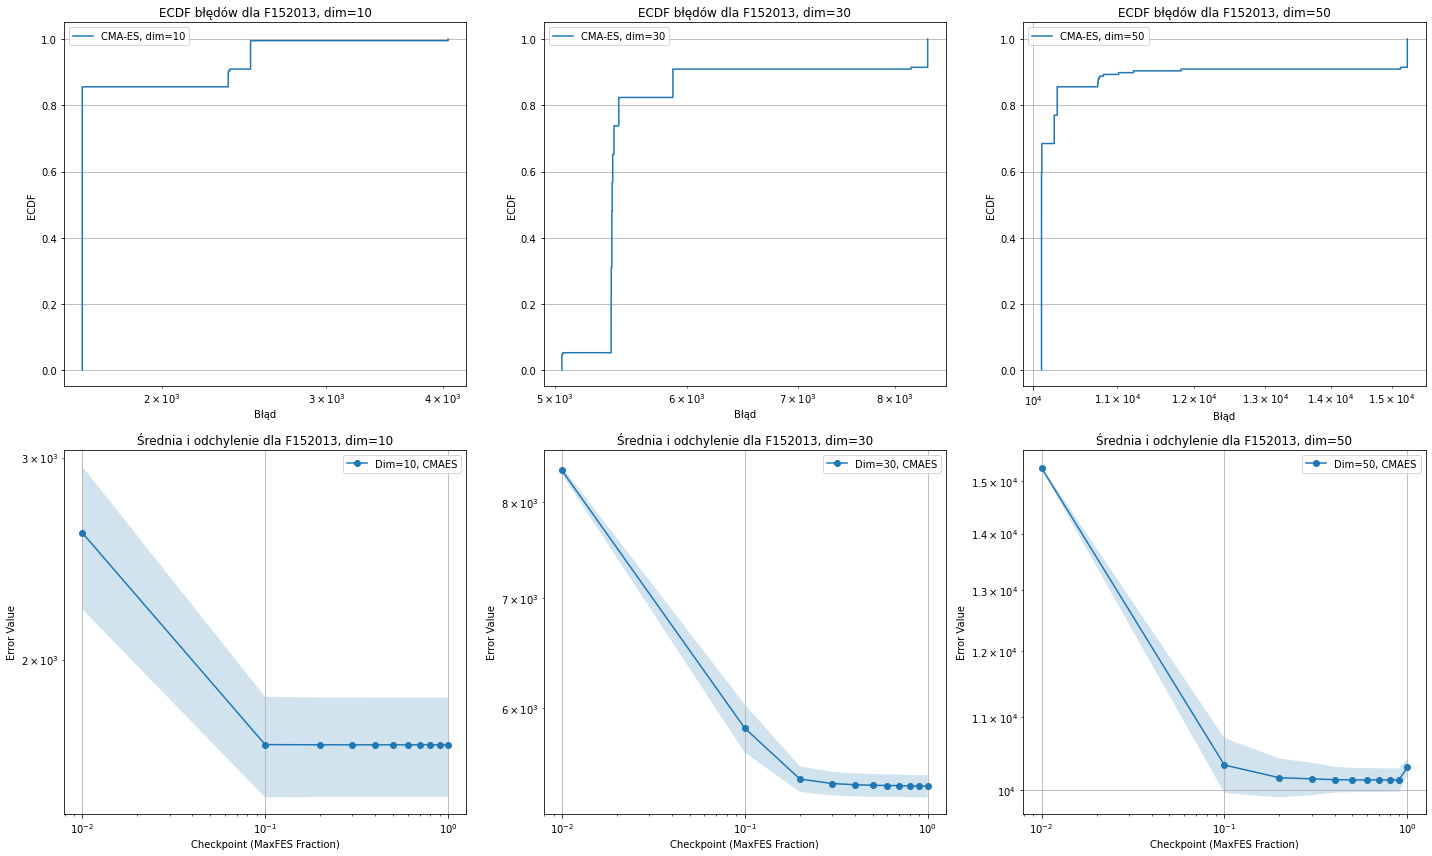

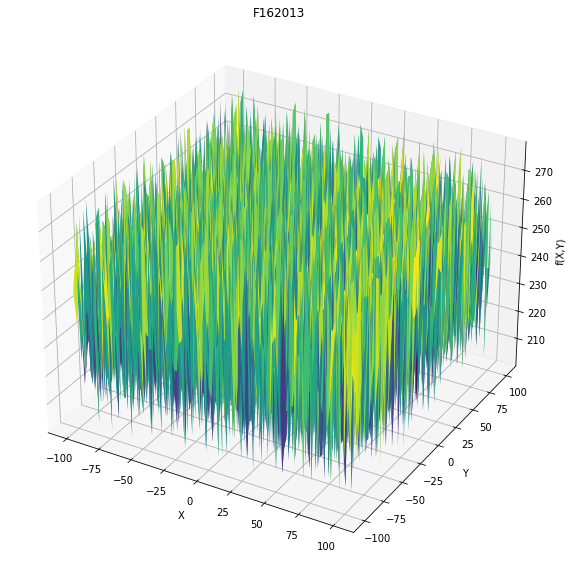

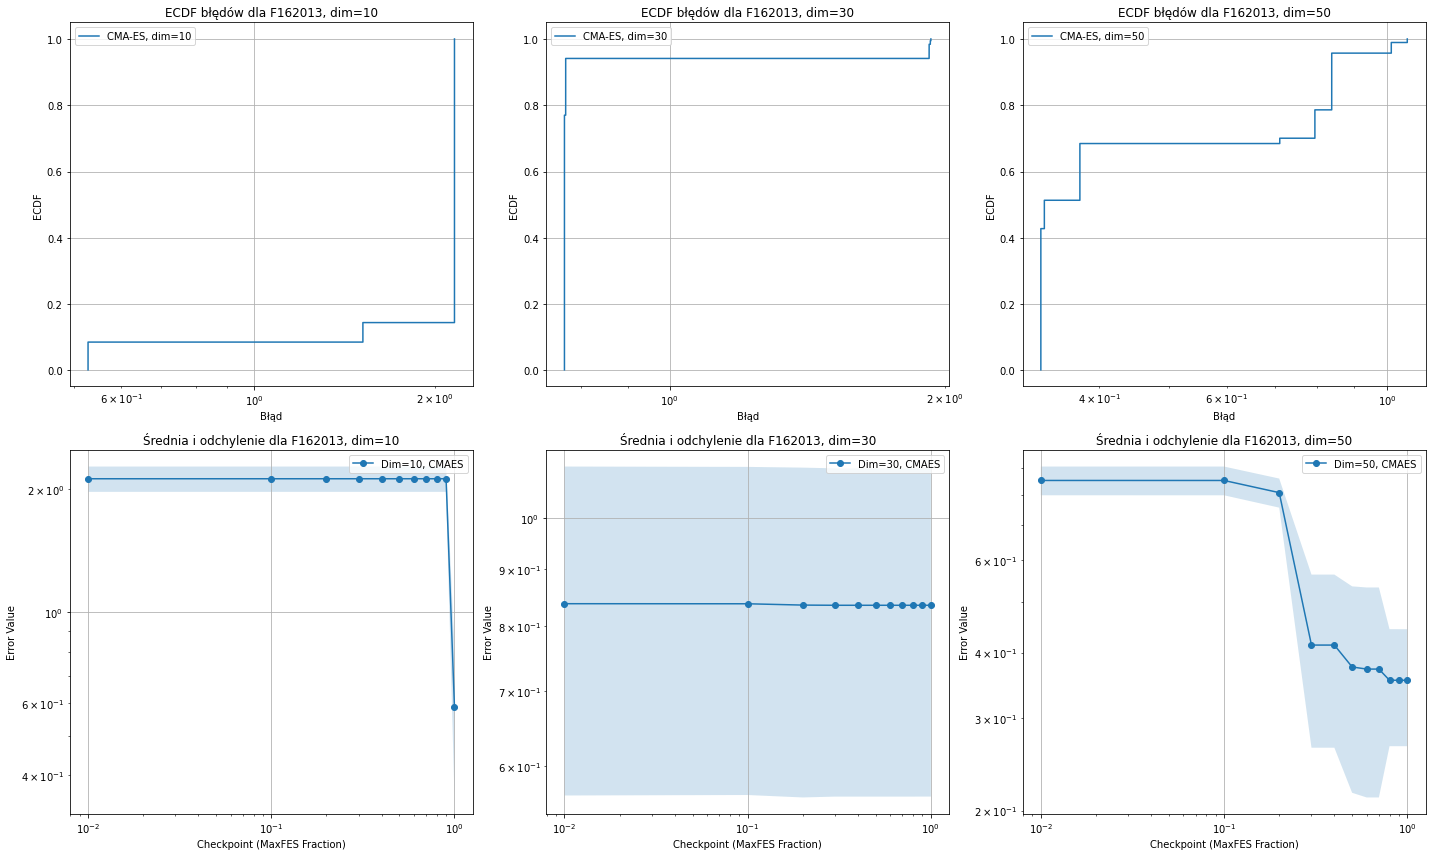

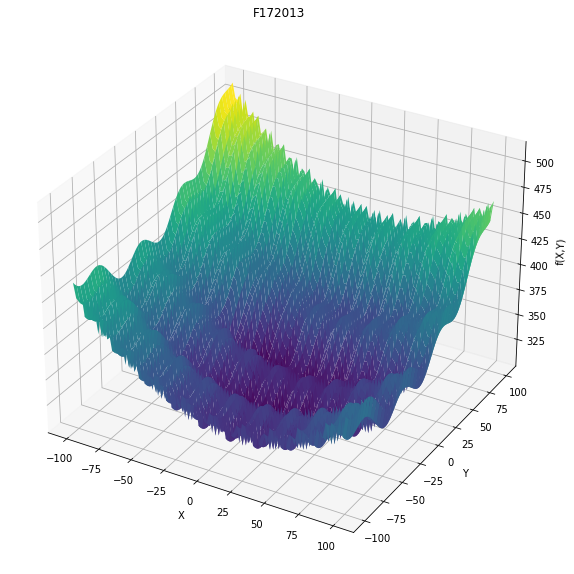

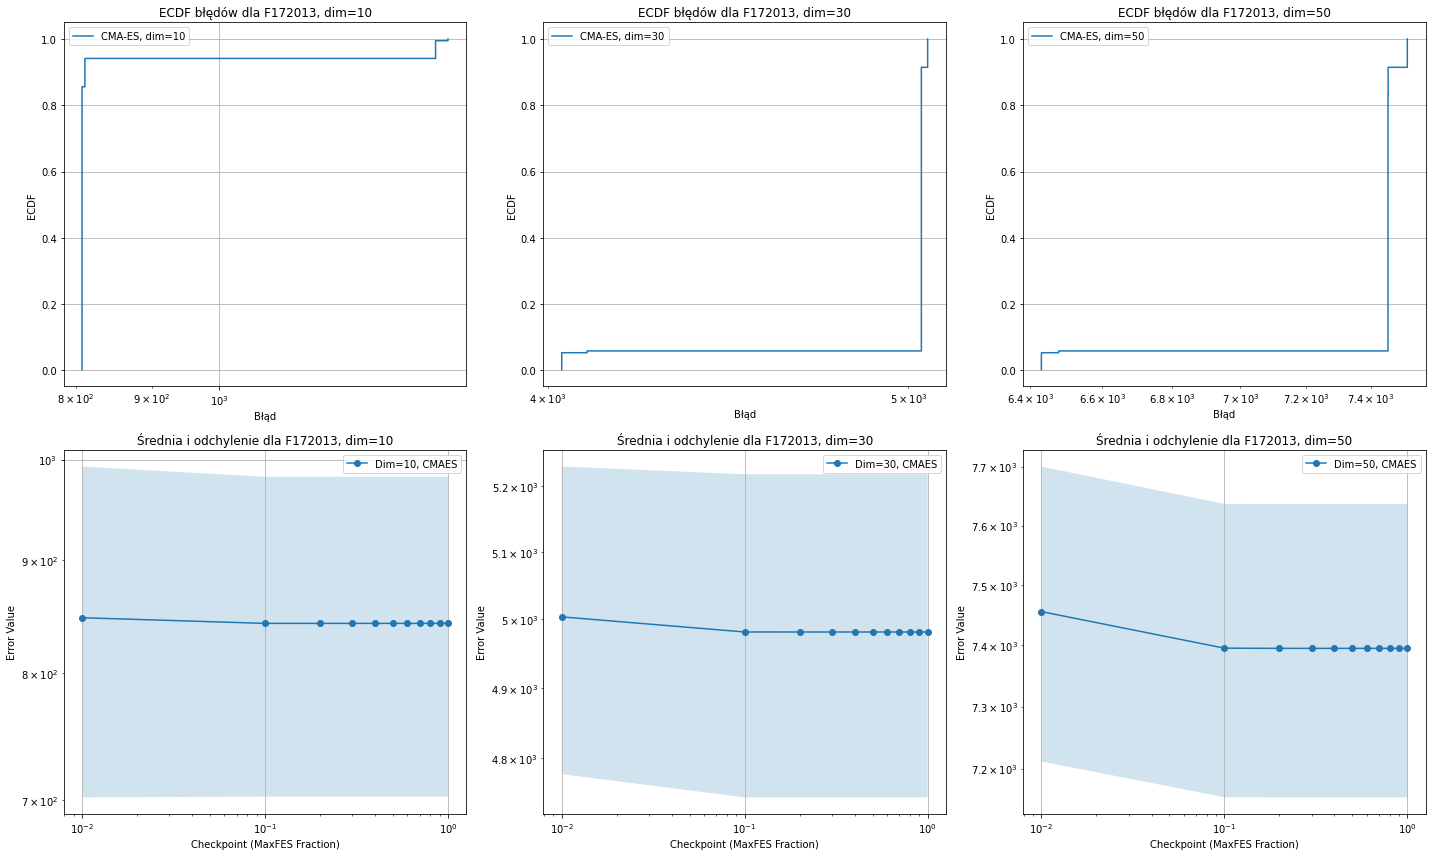

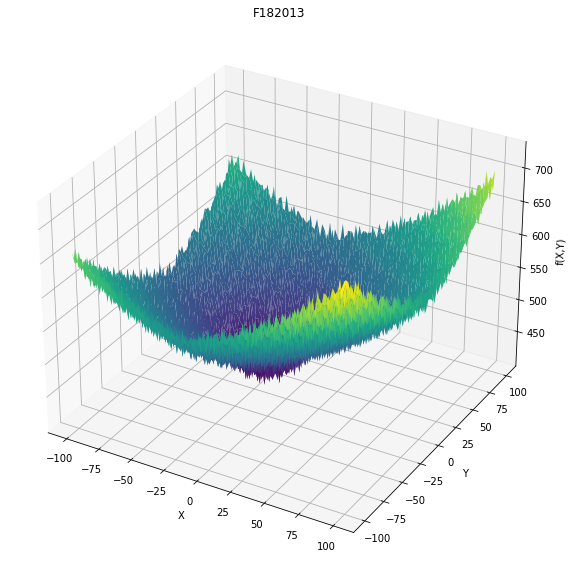

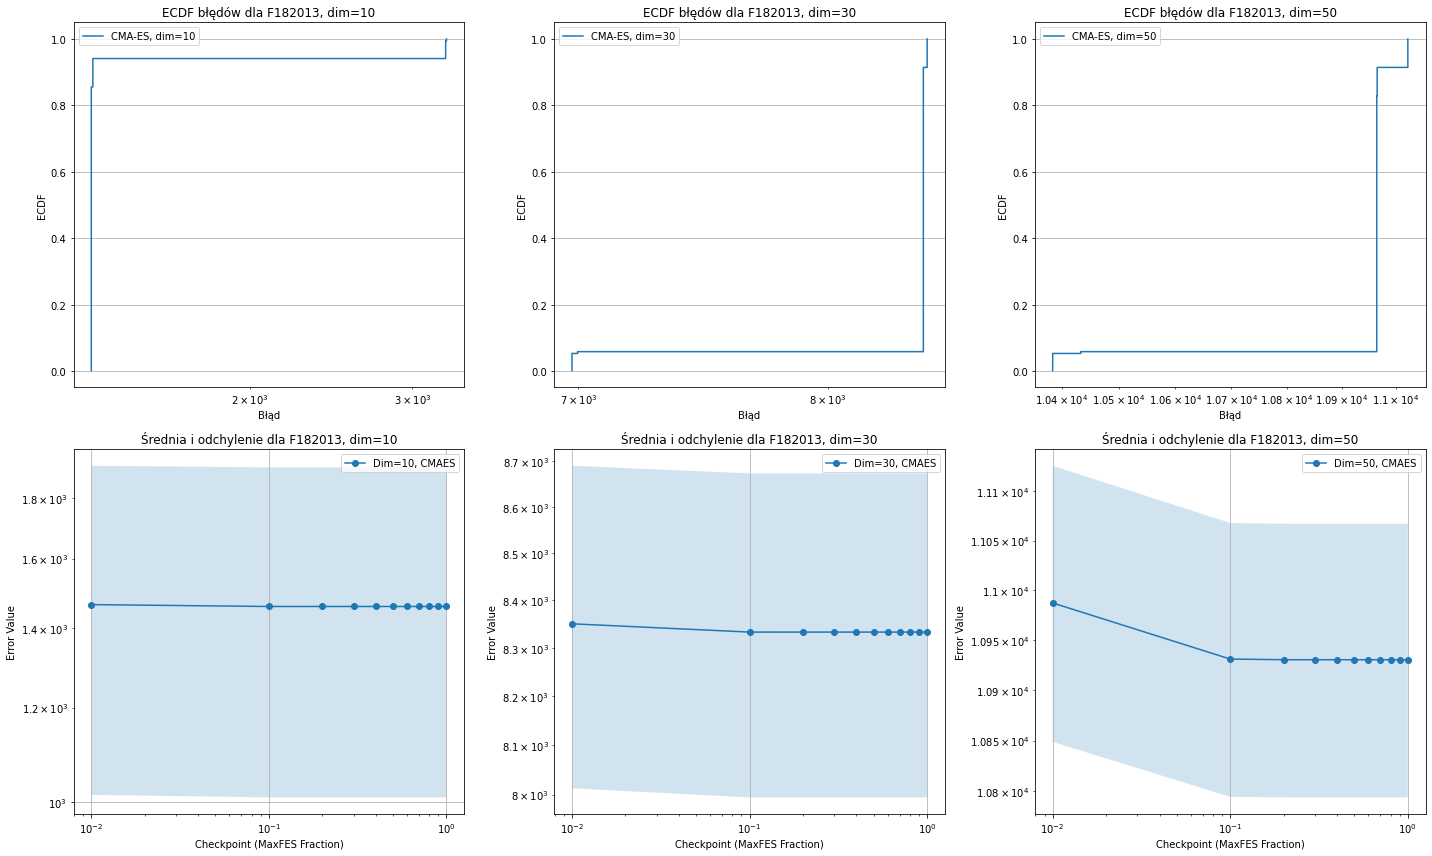

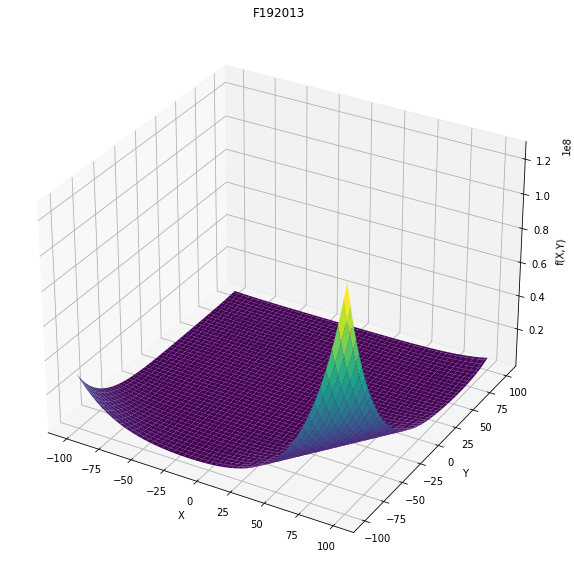

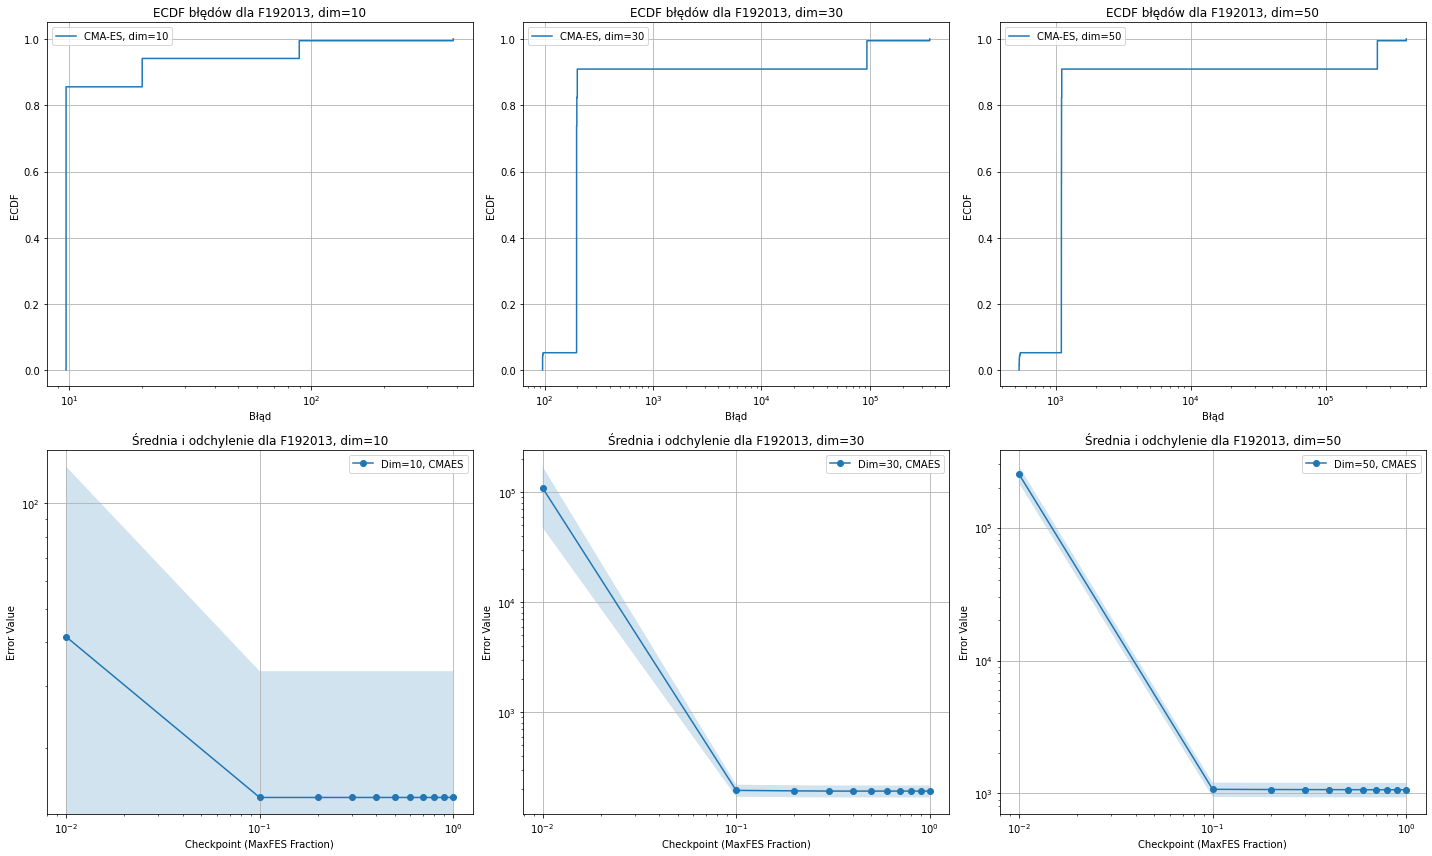

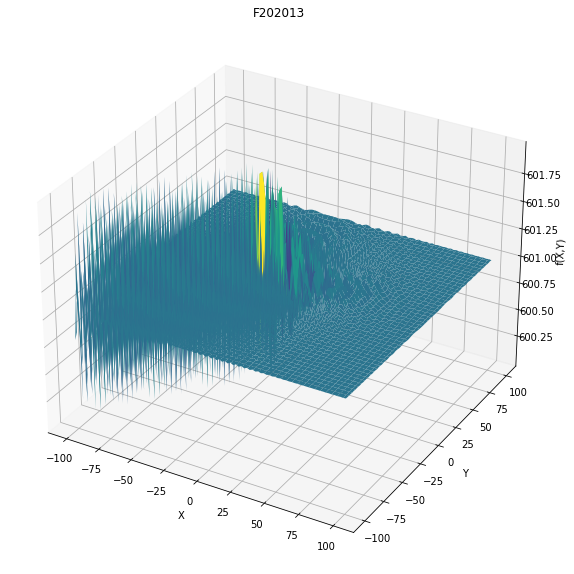

In [ ]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

for curr_f in globals.CEC2013:
    plot_function(curr_f)
    
    Adam_records, CMAES_records = get_records(curr_f)
    Adam_run_records, CMAES_run_records = get_run_records(curr_f)

    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    axs = axs.flatten()

    plot_idx = 0

    # ECDF
    for dim in globals.def_dimensions:
        ax = axs[plot_idx]
        for method_name, run_records in [("CMA-ES", CMAES_run_records), ("ADAM", Adam_run_records)]:
            if run_records is None:
                continue
            errors = [r['error'] for r in run_records if r['dimension'] == dim]
            if not errors:
                continue
            x, y = ecdf(errors)
            ax.step(x, y, where='post', label=f"{method_name}, dim={dim}")

        ax.set_xlabel('Błąd')
        ax.set_ylabel('ECDF')
        ax.set_title(f"ECDF błędów dla {curr_f['shortname']}, dim={dim}")
        ax.set_xscale('log')
        ax.legend()
        ax.grid(True)
        
        plot_idx += 1

    plot_idx = 0

    for dim in globals.def_dimensions:
        # Mean + Std
        ax = axs[plot_idx + len(globals.def_dimensions)]
        A_means_a = []
        A_stds_a = []
        C_means_a = []
        C_stds_a = []

        for checkpoint in globals.def_checkpoints:
            if Adam_records:
                A_means = [r['mean'] for r in Adam_records if r['dimensions'] == dim and r['checkpoint'] == checkpoint]
                A_stds = [r['std'] for r in Adam_records if r['dimensions'] == dim and r['checkpoint'] == checkpoint]
                A_means_a.append(np.mean(A_means) if A_means else 0)
                A_stds_a.append(np.mean(A_stds) if A_stds else 0)
            else:
                A_means_a.append(0)
                A_stds_a.append(0)

            if CMAES_records:
                C_means = [r['mean'] for r in CMAES_records if r['dimensions'] == dim and r['checkpoint'] == checkpoint]
                C_stds = [r['std'] for r in CMAES_records if r['dimensions'] == dim and r['checkpoint'] == checkpoint]
                C_means_a.append(np.mean(C_means) if C_means else 0)
                C_stds_a.append(np.mean(C_stds) if C_stds else 0)
            else:
                C_means_a.append(0)
                C_stds_a.append(0)

        if Adam_records:
            ax.plot(globals.def_checkpoints, A_means_a, label=f'Dim={dim}, ADAM', marker='o')
            ax.fill_between(globals.def_checkpoints,
                             np.array(A_means_a) - np.array(A_stds_a),
                             np.array(A_means_a) + np.array(A_stds_a), alpha=0.2)

        if CMAES_records:
            ax.plot(globals.def_checkpoints, C_means_a, label=f'Dim={dim}, CMAES', marker='o')
            ax.fill_between(globals.def_checkpoints,
                             np.array(C_means_a) - np.array(C_stds_a),
                             np.array(C_means_a) + np.array(C_stds_a), alpha=0.2)

        ax.set_xlabel('Checkpoint (MaxFES Fraction)')
        ax.set_ylabel('Error Value')
        ax.set_title(f"Średnia i odchylenie dla {curr_f['shortname']}, dim={dim}")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
        ax.grid(True)

        plot_idx += 1

    plt.tight_layout()
    plt.show()
